In [ ]:
import os
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as data
import torchvision
from PIL import Image,ImageOps
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt

!wget https://linguaschool.ru/img/temp/comnist.dict
if not os.path.isfile('Cyrillic.zip'):
  !wget https://linguaschool.ru/img/temp/Cyrillic.zip
  !unzip Cyrillic.zip
  !wget https://linguaschool.ru/img/temp/char_recognizer.pt
  

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: Cyrillic/Х/58bc3ac0c9b04.jpeg  
  inflating: Cyrillic/Х/58bc3ef0ec3c8.jpeg  
  inflating: Cyrillic/Х/58bc3f50cc509.jpeg  
  inflating: Cyrillic/Х/58bc4d5c2041b.jpeg  
  inflating: Cyrillic/Х/58bc51e089c96.jpeg  
  inflating: Cyrillic/Х/58bc5287bdd44.jpeg  
  inflating: Cyrillic/Х/58bc52bdb87ea.jpeg  
  inflating: Cyrillic/Х/58bc52d22a43d.jpeg  
  inflating: Cyrillic/Х/58bc52d866876.jpeg  
  inflating: Cyrillic/Х/58bc9a7aa17fc.jpeg  
  inflating: Cyrillic/Х/58bc9aff7c1e1.jpeg  
  inflating: Cyrillic/Х/58bd8f04e8e2b.jpeg  
  inflating: Cyrillic/Х/58bda73e68041.jpeg  
  inflating: Cyrillic/Х/58bda78faab0f.jpeg  
  inflating: Cyrillic/Х/58bda7eaf2cb8.jpeg  
  inflating: Cyrillic/Х/58bda80639ca4.jpeg  
  inflating: Cyrillic/Х/58bda811283d6.jpeg  
  inflating: Cyrillic/Х/58bda82d82add.jpeg  
  inflating: Cyrillic/Х/58bda83f91074.jpeg  
  inflating: Cyrillic/Х/58be7fedd7e8c.jpeg  
  inflating: Cyrillic/Х/58be80e6

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

#!cp *.dict /content/gdrive/MyDrive/

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
input_size = 224
if (0):
  from pathlib import Path
  import os
  !rm -R Cyrillic
  !rm -R /content/Cyrillic/I
  !unzip -q Cyrillic.zip
  for dirpath, dirs, files in os.walk("Cyrillic"): 
    for filename in files:
      fname = os.path.join(dirpath,filename)
      if fname.endswith('.png'):
            b, g, r, a = Image.open(fname).resize((input_size,input_size)).split()
            p = Path(fname).with_suffix('.jpeg')
            Image.merge("RGB", (a, a, a)).save(p)
            os.remove(fname)
  !zip -r data.zip Cyrillic


In [ ]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [ ]:
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  
device = torch.device(dev)  
print(device)


cuda:0


In [ ]:
DATA_MODES = ['train', 'val', 'test']
class MNISTDataset(Dataset):
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
    def set_mode(self, mode):
        self.mode = mode                    
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform_val = transforms.Compose([
            transforms.Grayscale(num_output_channels=3),                                             
            #transforms.Resize(RESCALE_SIZE),
            #transforms.CenterCrop(RESCALE_SIZE),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            #transforms.Normalize([0.5], [0.5]) 
        ])
        transform_train = transforms.Compose([
            transforms.Grayscale(num_output_channels=3),
            transforms.RandomResizedCrop(228,scale=(0.7,1)),
            transforms.RandomRotation(5),
            #transforms.RandomErasing(p=0.8),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            #transforms.Normalize([0.5], [0.5]) 
        ])
        x = self.load_sample(self.files[index])
        if self.mode == 'train':
          x = transform_train(x)
        else:
          x = transform_val(x)

        if self.mode == 'test':
            return x
        else:

            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

class MNISTSubset:
    # dataset: SimpsonsDataset[T_co]
    # indices: Sequence[int]
    def __init__(self, dataset, indices, mode):
        self.dataset = copy.deepcopy(dataset)
        self.indices = indices
        self.dataset.set_mode(mode)

    def set_mode(self, mode='test'):
        self.dataset.set_mode(mode)
    def __getitem__(self, idx):
        return self.dataset[self.indices[idx]]
    def __len__(self):
        return len(self.indices)



def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    if inp.shape[2]==1:
      inp = inp[:,:,0]
    mean = np.array([0.485])
    std = np.array([0.229])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)


TRAIN_DIR = Path('Cyrillic')
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpeg')))
val_dataset = MNISTDataset(train_val_files, mode='train')
num_classes = len(np.unique([path.parent.name for path in train_val_files]))
print("we will classify :{}".format(num_classes))

we will classify :33


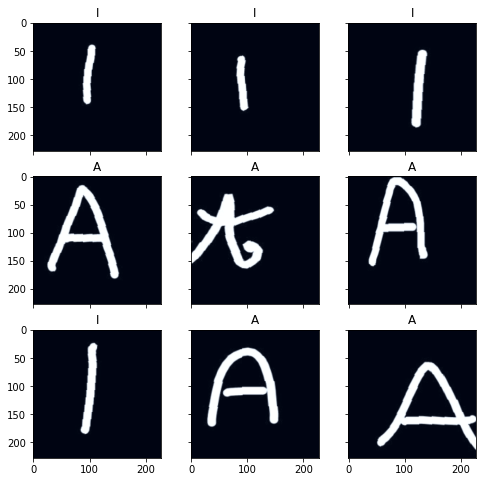

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,500))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
 
    imshow(im_val.data.cpu(), \
           title=img_label,plt_ax=fig_x)

In [ ]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
def train_model_epoch(model, dataloaders, criterion, optimizer, is_inception=False):
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        #print(inputs.shape)
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        return model, epoch_acc

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
feature_extract = False
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 128, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        #self.fc1 = nn.Linear(131072, 2048)
        self.fc3 = nn.Linear(2048, 512)
        self.fc5 = nn.Linear(512, 44)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.reshape(x.size(0), -1) 
        #print(x.size())
        #x = x.view(-1, 131072)
        #x = F.relu(self.fc1(x))
        #x = F.dropout(x, training=self.training)
        x = F.relu(self.fc3(x))
        x = F.dropout(x, training=self.training)
        x = self.fc5(x)
        return x

from torchvision import models
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

model_ft = models.resnet18(pretrained=True)
set_parameter_requires_grad(model_ft, feature_extract)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, num_classes)


import torch.optim as optim
model_ft = model_ft.to(device)

params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

print(model_ft)




#model_ft = Net() 
#model_ft.to(device)
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
print(model_ft)            

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight
	 layer3.1.

In [ ]:
#@попытка использовать stratified kfold
from sklearn.model_selection import StratifiedKFold
model_ft.load_state_dict(torch.load('comnist.dict'))
model_ft.eval()
num_epochs = 50
KFoldSplits=5
batch_size=128
dataloaders={}
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpeg')))
train_val_labels = [path.parent.name for path in train_val_files]

skf = StratifiedKFold(n_splits=KFoldSplits)
imagesdataset = MNISTDataset(train_val_files, mode='val')

since = time.time()
val_acc_history = []
best_model_wts = copy.deepcopy(model_ft.state_dict())
best_acc = 0.0
for epoch in range(num_epochs//KFoldSplits):
   for train_index, test_index in skf.split(imagesdataset, train_val_labels):
        train_dataset = MNISTSubset(imagesdataset, train_index, 'train')
        val_dataset = MNISTSubset(imagesdataset, test_index,'val')
        dataloaders['train'] = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        dataloaders['val']   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        model_ft, epoch_acc = train_model_epoch(model_ft, dataloaders, criterion, optimizer_ft, is_inception=False)
        # deep copy the model
        if epoch_acc >= best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model_ft.state_dict())
        val_acc_history.append(epoch_acc)

 
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best val Acc: {:4f}'.format(best_acc))
torch.save(model_ft.state_dict( ), 'comnist.dict')
model_ft.load_state_dict(best_model_wts)
torch.save(model_ft.state_dict( ), 'comnist_best.dict')
#return model, val_acc_history   



Epoch 0/49
----------
train Loss: 0.0165 Acc: 0.9960
val Loss: 0.0048 Acc: 0.9997
Epoch 0/49
----------
train Loss: 0.0135 Acc: 0.9974
val Loss: 0.0031 Acc: 0.9997
Epoch 0/49
----------
train Loss: 0.0132 Acc: 0.9973
val Loss: 0.0056 Acc: 0.9987
Epoch 0/49
----------
train Loss: 0.0152 Acc: 0.9965
val Loss: 0.0038 Acc: 0.9997
Epoch 0/49
----------
train Loss: 0.0124 Acc: 0.9971
val Loss: 0.0071 Acc: 0.9974
Epoch 1/49
----------
train Loss: 0.0159 Acc: 0.9967
val Loss: 0.0044 Acc: 0.9993
Epoch 1/49
----------
train Loss: 0.0138 Acc: 0.9974
val Loss: 0.0040 Acc: 0.9997
Epoch 1/49
----------
train Loss: 0.0146 Acc: 0.9971
val Loss: 0.0053 Acc: 0.9984
Epoch 1/49
----------
train Loss: 0.0160 Acc: 0.9963
val Loss: 0.0035 Acc: 0.9997
Epoch 1/49
----------
train Loss: 0.0133 Acc: 0.9967
val Loss: 0.0078 Acc: 0.9974
Epoch 2/49
----------
train Loss: 0.0137 Acc: 0.9971
val Loss: 0.0063 Acc: 0.9977
Epoch 2/49
----------
train Loss: 0.0130 Acc: 0.9971
val Loss: 0.0053 Acc: 0.9987
Epoch 2/49
-----

--------